In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

from IPython.display import clear_output

In [2]:
import fulu
import utils
from binned_split import binned_train_test_split
from copy import deepcopy

/Users/mikhail/opt/anaconda3/envs/fulu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from joblib import Parallel, delayed

In [4]:
import warnings
# warnings.filterwarnings("ignore")

# Read data

In [5]:
data = pd.read_csv('../data/plasticc/good_objects.csv.gz')

data = data[data.detected_bool == 1]

In [6]:
data.head()

,good_objects.csv,object_id,mjd,passband,flux,flux_err,detected_bool,log_lam,class
0,924.0,730.0,60532.3019,2.0,20.994711,1.047298,1.0,3.790512,0.0
1,926.0,730.0,60532.3173,3.0,31.523088,1.569497,1.0,3.875155,0.0
2,927.0,730.0,60532.3282,4.0,41.159981,2.310168,1.0,3.938479,0.0
3,928.0,730.0,60532.3392,5.0,46.795868,5.458707,1.0,3.987288,0.0
4,931.0,730.0,60535.2957,3.0,30.361010,2.107024,1.0,3.875155,0.0


In [7]:
object_ids = np.unique(data.object_id)

In [8]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

# Utils

In [9]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id].copy()
    return anobject

In [10]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [11]:
def add_log_lam(anobject):
    passbands = anobject.passband.values
    log_lam = [passband2lam[i] for i in passbands]
    anobject.loc[:, 'log_lam'] = log_lam
    return anobject

In [12]:
def is_good(anobject):
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        return 0
    
    # keep only objects with at least 7 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 7:
            count += 1
    if count > 3:
        return 0
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        return 0
    
    return 1

# Visualization

In [13]:
def plot_light_curves(anobject, title="", is_plot=True):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 5.5))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        if is_plot:
            plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=20)
    plt.xticks(size=18)
    plt.ylabel('Flux', size=20)
    plt.yticks(size=18)
    plt.legend(loc='best', ncol=3, fontsize=18)
    plt.title(title, size=18)

In [14]:
def plot_light_curves_with_sigma(t, flux, flux_err, passband, title=""):
    colors = ['C'+str(i) for i in range(len(np.unique(passband)))]
    plt.figure(figsize=(9, 5.5))
    for i, pb in enumerate(np.unique(passband)):
        plt.plot(t[passband == pb], flux[passband == pb], linewidth=2., color=colors[i])
        plt.fill_between(t[passband == pb], 
                         flux[passband == pb]+1*flux_err[passband == pb], 
                         flux[passband == pb]-1*flux_err[passband == pb], label=passband2name[pb], alpha=0.5, color=colors[i])
    plt.xlabel('Modified Julian Date', size=20)
    plt.xticks(size=18)
    plt.ylabel('Flux', size=20)
    plt.yticks(size=18)
    plt.legend(loc='best', ncol=3, fontsize=18)
    plt.title(title, size=18)

13.0


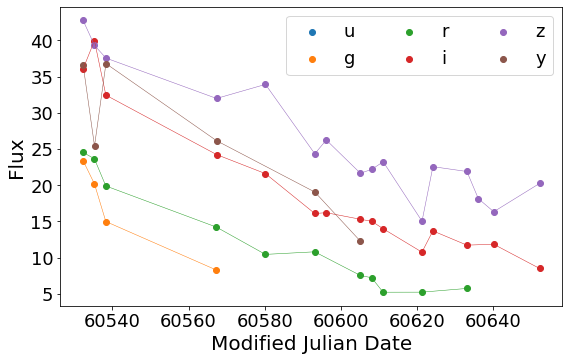

88.0


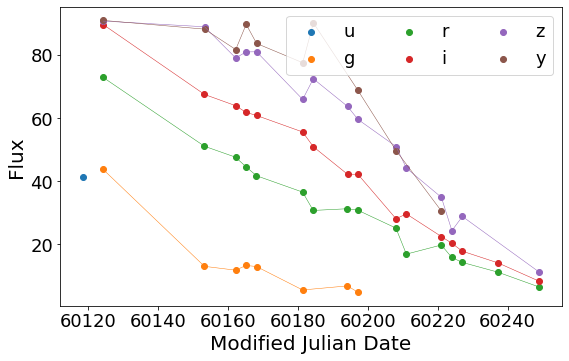

96.0


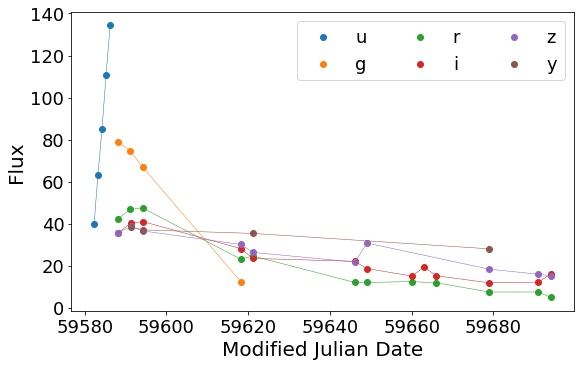

176.0


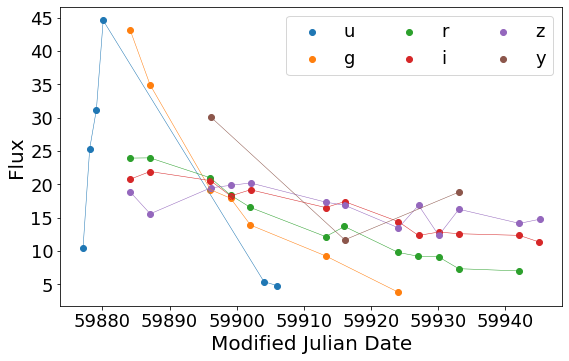

195.0


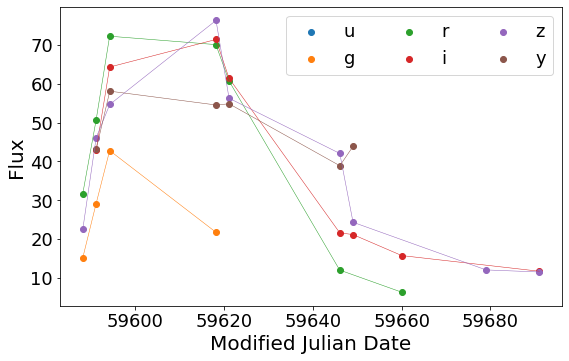

198.0


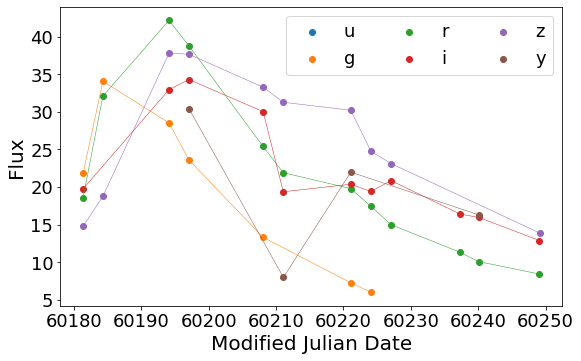

In [15]:
for i in object_ids[:20]:
    anobject = get_object(data, i)
    if not is_good(anobject):
        continue
    print(i)
    plot_light_curves(anobject)
    plt.show()

# One object test Test

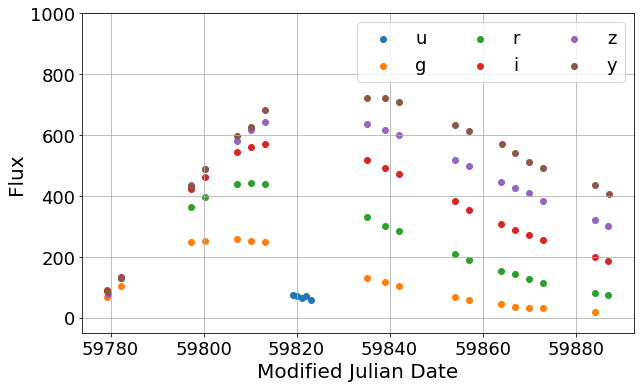

In [16]:
anobject = get_object(data, 34299) # 34299, 329277
anobject = add_log_lam(anobject)
anobject['flux'] += 1*np.random.normal(0, anobject['flux_err'], len(anobject))

plot_light_curves(anobject, is_plot=False)
plt.grid()
plt.ylim(-50, 1000)
plt.tight_layout()
plt.savefig('img/light_curve_34299.pdf', format='pdf')
plt.savefig('img/light_curve_34299.png', format='png')

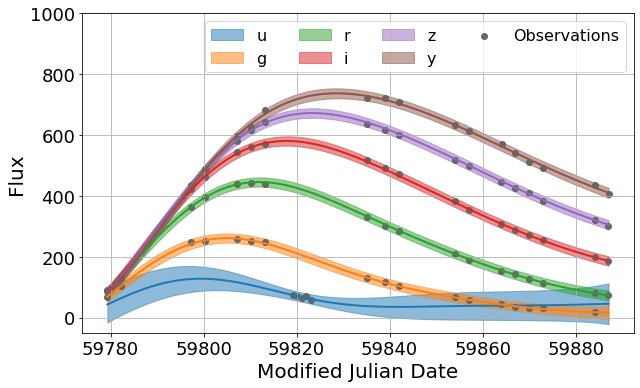

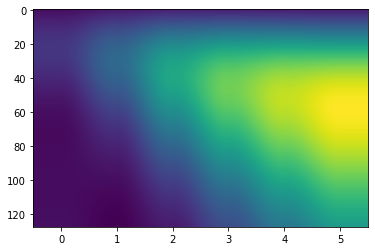

In [17]:
# train test split
t = anobject['mjd'].values
flux = anobject['flux'].values #+ np.random.normal(0, 30, len(t))
flux_err = anobject['flux_err'].values
passband = anobject['passband'].values

# approximation model
aug = fulu.GaussianProcessesAugmentation(passband2lam)
aug.fit(t, flux, flux_err, passband)

# augmentation
t_aug, flux_aug, flux_err_aug, passband_aug= aug.augmentation(t_min=t.min(), t_max=t.max(), n_obs=128)

# convert values to 2D-array
data_array = flux_aug.reshape((6, 128))

# add target value for this curve
true_class = int(anobject['class'].to_numpy()[0])


# plotting
plot_light_curves_with_sigma(t_aug, flux_aug, 3*flux_err_aug, passband_aug, title="")
plt.scatter(t, flux, label='Observations', color='0.4')
plt.legend(loc='best', ncol=4, fontsize=16)
plt.ylim(-50, 1000)
plt.grid()
plt.tight_layout()
plt.savefig('img/light_curve_aug_gp_34299.pdf', format='pdf')
plt.savefig('img/light_curve_aug_gp_34299.png', format='png')
plt.show()

plt.imshow(data_array.T, aspect='auto')
plt.show()

In [18]:
def plot_light_curves_without_sigma(t, flux, flux_err, passband, title=""):
    colors = ['C'+str(i) for i in range(len(np.unique(passband)))]
    plt.figure(figsize=(9, 5.5))
    for i, pb in enumerate(np.unique(passband)):
        plt.plot(t[passband == pb], flux[passband == pb], linewidth=5., color=colors[i], label=passband2name[pb])
    plt.xlabel('Modified Julian Date', size=20)
    plt.xticks(size=18)
    plt.ylabel('Flux', size=20)
    plt.yticks(size=18)
    plt.legend(loc='best', ncol=3, fontsize=18)
    plt.title(title, size=18)

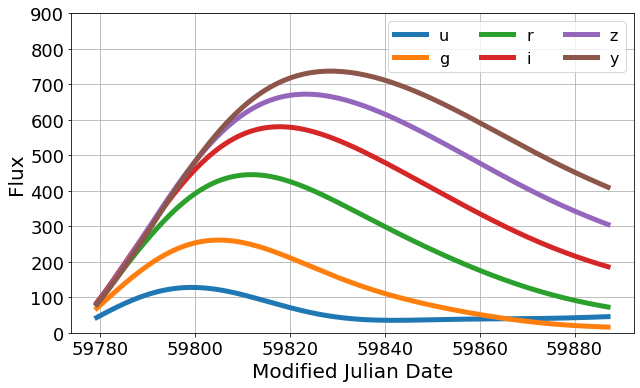

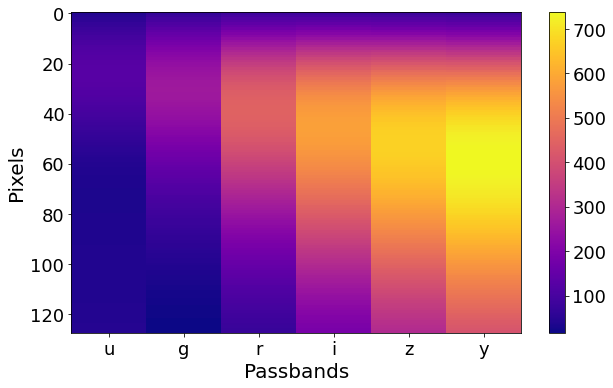

In [19]:
from matplotlib import cm

# plotting
plot_light_curves_without_sigma(t_aug, flux_aug, 3*flux_err_aug, passband_aug, title="")
#plt.scatter(t, flux, label='Observations', color='0.4')
plt.legend(loc='best', ncol=3, fontsize=16)
plt.ylim(-0, 900)
plt.grid()
plt.tight_layout()
plt.savefig('img/light_curve_aug_gp_mu_34299.pdf', format='pdf')
plt.savefig('img/light_curve_aug_gp_mu_34299.png', format='png')
plt.show()

plt.figure(figsize=(9, 5.5))
plt.imshow(data_array.T, aspect='auto', interpolation='nearest', cmap=cm.plasma)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=18)
plt.xlabel('Passbands', size=20)
plt.xticks(range(6), ['u', 'g', 'r', 'i', 'z', 'y'], size=18)
plt.ylabel('Pixels', size=20)
plt.yticks(size=18)
plt.tight_layout()
plt.savefig('img/light_curve_aug_gp_img_34299.pdf', format='pdf')
plt.savefig('img/light_curve_aug_gp_img_34299.png', format='png')
plt.show()

# Image preparation

In [20]:
N_obs = 128

In [21]:
def get_images(outputs, silent=False):
    images = []
    labels = []
    for img in outputs:
        if img is not None:
            labels.append(img[0])
            images.append(img[1])
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [22]:
def one_object_run(i):
    
    warnings.filterwarnings("ignore")
    
    # get an object
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)
    
    # take only good curves
    if not is_good(anobject): 
        return None
    
    # train test split
    t = anobject['mjd'].values
    flux = anobject['flux'].values
    flux_err = anobject['flux_err'].values
    passband = anobject['passband'].values
    
    # approximation model
    if MODEL == "GP":
        aug = fulu.GaussianProcessesAugmentation(**params)
    elif MODEL == "NN_sklearn":
        aug = fulu.MLPRegressionAugmentation(**params)
    elif MODEL == "NN_pytorch":
        aug = fulu.SingleLayerNetAugmentation(**params)
    elif MODEL == "BNN":
        aug = fulu.BayesianNetAugmentation(**params)
    elif MODEL == "NF":
        aug = fulu.NormalizingFlowAugmentation(**params)

    # fit the model
    aug.fit(t, flux, flux_err, passband)

    # augmentation
    t_aug, flux_aug, flux_err_aug, passband_aug= aug.augmentation(t_min=t.min(), t_max=t.max(), n_obs=N_obs)

    # convert values to 2D-array
    image = flux_aug.reshape((6, N_obs))

    # add target value for this curve
    true_class = int(anobject['class'].to_numpy()[0])
    
    #return (true_class, [image])
    return (true_class, image)

# Classifier preparation

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from sklearn.model_selection import train_test_split
# from tqdm.notebook import tqdm

device = 'cpu'

# model for binary classificiation: Supernova Ia VS others
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn = nn.Sequential(
                                    nn.Conv1d(6, 8, 3, padding=1),
                                    nn.LayerNorm((8, 128)),
                                    nn.ReLU(),
                                    nn.MaxPool1d(2),
                                    nn.Conv1d(8, 16, 3, padding=1),
                                    nn.LayerNorm((16, 64)),
                                    nn.ReLU(),
                                    nn.MaxPool1d(2),
                                    nn.Conv1d(16, 32, 3, padding=1),
                                    nn.LayerNorm((32, 32)),
                                    nn.ReLU(),
                                    nn.MaxPool1d(2),
                                    nn.Flatten(),
                                    nn.Dropout(0.33),
                                    nn.Linear(16 * 32, 1),
                                    nn.Sigmoid()
                                )

    def forward(self, x):
        x = self.cnn(x)
        return x

In [24]:
Net()

Net(
  (cnn): Sequential(
    (0): Conv1d(6, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): LayerNorm((8, 128), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): LayerNorm((16, 64), eps=1e-05, elementwise_affine=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): LayerNorm((32, 32), eps=1e-05, elementwise_affine=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten()
    (13): Dropout(p=0.33, inplace=False)
    (14): Linear(in_features=512, out_features=1, bias=True)
    (15): Sigmoid()
  )
)